Library

In [1]:
import pytesseract
import glob
from sklearn.cluster import KMeans
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import re

In [2]:
def textProcessing(texts):
    NIKS=[]
    for text in texts:
        NIK= re.findall(r'\b\w*35\w*\b', text)
        NIKS.append(NIK)
    return NIKS
    

In [3]:
def pathProcessing (path):
    image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.gif']  # Add more extensions if needed
    image_paths = []

    for ext in image_extensions:
        image_paths.extend(glob.glob(os.path.join(path, ext)))

    return image_paths

In [4]:
def gaussianBlur(images):
    blurredImages=[]
    for image in images:
        kernel_size = (5, 5)
        sigma_x = 0
        blurredImage = cv2.GaussianBlur(image, kernel_size, sigma_x)
        blurredImages.append(blurredImage)
    
    return blurredImages   

In [5]:
def readImage (paths):
    images=[]

    for path in paths:
        image= cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        if image is not None:
            images.append(image)
        else:
            print(f"Failed to read image at path: {path}")

    return images

In [6]:
def kmeans(images):
    newImages=[]
    for image in images : 
        k = 2
        newImage = image.reshape((-1, 1))
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(newImage)
        cluster_centers = kmeans.cluster_centers_.astype(np.uint8)
        segmented_image = cluster_centers[kmeans.labels_].reshape(image.shape)
    newImages.append(segmented_image)
    
    return segmented_image

In [7]:
from PIL import Image
import cv2
import numpy as np

def imageToText(images):
    texts = []
    for image in images:
        # Ubah gambar dari cv2 (numpy array) menjadi gambar PIL
        pil_image = Image.fromarray(image)

        # Ubah gambar menjadi mode grayscale ('L')
        image_for_ocr = pil_image.convert('L')

        pytesseract.pytesseract.tesseract_cmd = "C:\\Program Files\\Tesseract-OCR\\tesseract.exe"
        text = pytesseract.image_to_string(image_for_ocr)
        texts.append(text)

    return texts

In [8]:
# konvolusi pada gambar
def convolution2d(images,kernel,stride,padding):
    
    convolvedImages=[]
    for image in images:
      image_height, image_width = image.shape
      kernel_height, kernel_width = kernel.shape

      padded_image = np.zeros((image_height + kernel_height - 1, image_width + kernel_width - 1))
      padded_image[kernel_height // padding:image_height + kernel_height // padding, kernel_width // padding:image_width + kernel_width // padding] = image

      convolved_image = np.zeros((image_height, image_width))
      for i in range(image_height):
        for j in range(image_width):
          convolved_image[i, j] = np.sum(padded_image[i*stride:i*stride + kernel_height, j*stride:j*stride + kernel_width] * kernel)
      convolvedImages.append(convolved_image)

    return convolvedImages

In [9]:
def showImages(images, num_cols=3):
    num_images = len(images)
    num_rows = (num_images + num_cols - 1) // num_cols

    plt.figure(figsize=(10, 8))  # Atur ukuran figur sesuai kebutuhan

    for i, image in enumerate(images, 1):
        plt.subplot(num_rows, num_cols, i)
        plt.imshow(image, cmap='gray')  # Menggunakan cmap='gray' jika gambar dalam mode grayscale
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [10]:
def adaptive(images):
    thresholded=[]
    for image in images:
        adaptive_threshold = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
        thresholded.append(adaptive_threshold)
    return thresholded

In [11]:
def otsuThresholding(images):
    thresholded=[]
    for image in images:
        normalizedImage = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
        ret, otsu_threshold = cv2.threshold(normalizedImage, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        thresholded.append(otsu_threshold)
    return thresholded

In [12]:
def main ():
    path= 'DataSet'
    imagesPath=pathProcessing(path)
    imageReady=readImage(imagesPath)
    normalImage=imageReady
    blurredImages=gaussianBlur(imageReady)
    kernel = np.array([[0, -1, 0],
                      [-1, 5, -1],
                      [0, -1, 0]])
    convolved_image = convolution2d(blurredImages, kernel, 1, 2)
    
    texts=imageToText(convolved_image)
    NIK=textProcessing(texts)
    
    return {
        "path":imagesPath,
        "normalImage": normalImage,
        "images":convolved_image,
        "text": texts,
        "NIK": NIK
    }
    
    

In [13]:
data=main()

In [14]:
print(data["NIK"])

[['35040'], [], [], [], [], ['350'], ['350517210203000e'], ['35141331108030001'], [], [], ['350b142b09020003'], ['3573040505030005'], ['351109240'], ['3571020309030003'], [], ['35051953090c000e2'], [], ['3579010209020092'], [], ['3516112404030001'], ['35040'], ['3514101803030001'], ['352404'], [], ['3506105703']]


In [15]:
print(data["text"][0])

PROVINS! JAWA TIMUR

KABUPATEN TULUNGAGUNG
NIK ¢ 35040?t11e0e0002
: AURA SAGITA AGHILAH
Tempat/Tgi Lahir TULUNGAGUNG, 21.12.2002
Jeniskelamin . PEREMPUAN Go
Alamat OSN WINONG

Pekerjaan - PELAJARAMAHASISWA




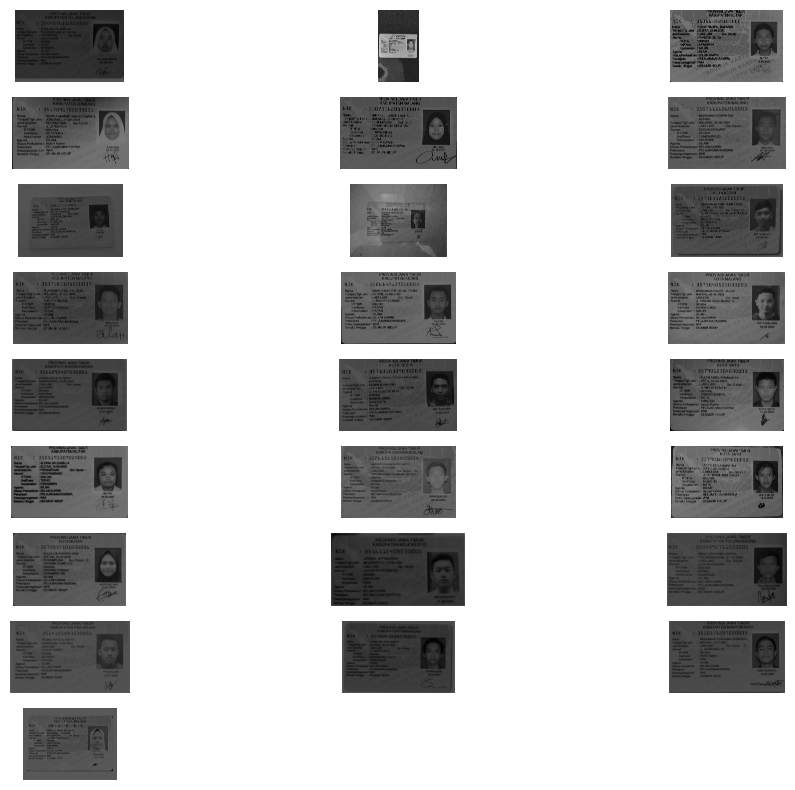

In [16]:
showImages(data["images"])

In [18]:
import pandas as pds

datax = {
    'path':data['path'],
    'image': data["normalImage"],
    'Text': data["text"],
}
df = pd.DataFrame(datax)

df.to_csv('output.csv', index=False) 